In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import print_function

from   collections import OrderedDict
import math
import matplotlib.pyplot as plt
import numpy as np
from   local import MNISTNet, alexnet_local
import local
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from   torchvision import datasets, transforms
from   torch.autograd import Variable
import torch.nn.functional as F
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
USE_MNIST = False
LAYER_SIZE = 49 if USE_MNIST else 4096
LAYER_SIZE_SQ = int(math.sqrt(LAYER_SIZE))

In [52]:
def show_activations(ax, activation, title):
    ax.set_title(title)
    im = ax.imshow(np.reshape(activation, (LAYER_SIZE_SQ,LAYER_SIZE_SQ)),
           cmap='hot', interpolation='nearest')
    plt.colorbar(im)

def average_activations(activations, targets, target):
    print("N:", (targets==target).sum())
    return activations[targets==target].mean(axis=0)

## Load Models
---

In [4]:
if USE_MNIST:
    # Load classic model
    classic_model = MNISTNet(use_local=False)
    classic_model.training = False
    classic_optimizer = optim.SGD(classic_model.parameters(), lr=0.01, momentum=0.9)
    checkpoint = torch.load("unknown_model/checkpoint.pth.tar")
    # checkpoint = torch.load("runs/run-classic/checkpoint-classic.pth.tar")
    start_epoch = checkpoint['epoch']
    classic_model.load_state_dict(checkpoint['state_dict'])
    classic_optimizer.load_state_dict(checkpoint['optimizer'])

In [15]:
if not USE_MNIST:
    # Load classic model
    classic_model = alexnet_local(use_local=False)
    classic_model.training = False
    classic_model.features = torch.nn.DataParallel(classic_model.features)
    classic_model.cuda()
    classic_optimizer = optim.SGD(classic_model.parameters(), lr=0.01, momentum=0.9)
    checkpoint = torch.load("runs/run-alexnet/checkpoint-classic.pth.tar")
    start_epoch = checkpoint['epoch']
    classic_model.load_state_dict(checkpoint['state_dict'])
    classic_optimizer.load_state_dict(checkpoint['optimizer'])

In [5]:
if USE_MNIST:
    # Load local model
    local_model = MNISTNet(use_local=True)
    local_model.training = False
    local_optimizer = optim.SGD(local_model.parameters(), lr=0.01, momentum=0.9)
    # checkpoint_local = torch.load("runs/run-local/checkpoint-local.pth.tar")
    checkpoint = torch.load("unknown_model/checkpoint.pth.tar")
    start_epoch = checkpoint_local['epoch']
    local_model.load_state_dict(checkpoint_local['state_dict'])
    local_optimizer.load_state_dict(checkpoint_local['optimizer'])

In [96]:
if not USE_MNIST:
    # Load local model
    local_model = alexnet_local()
    local_model.training = False
    local_model.features = torch.nn.DataParallel(local_model.features)
    local_model.cuda()
    local_optimizer = optim.SGD(local_model.parameters(), lr=0.01, momentum=0.9)
#     checkpoint_local = torch.load("runs/run-alexnet_local/checkpoint-local.pth.tar")

    checkpoint_local = torch.load("checkpoint.pth.tar")
    start_epoch = checkpoint_local['epoch']
    local_model.load_state_dict(checkpoint_local['state_dict'])
    local_optimizer.load_state_dict(checkpoint_local['optimizer'])

## Visualize prior
---

In [98]:
prior = local_model.fc15.prior.numpy() if USE_MNIST else local_model.fc6_.prior.cpu().numpy()
test_prior = local.prior_2d(LAYER_SIZE, LAYER_SIZE, topology='euclidean', weight_fn=lambda x: x**2)

109.76587

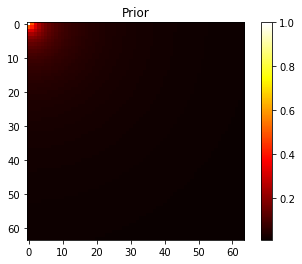

In [99]:
f = plt.figure()
show_activations(f.add_subplot(1,1,1), prior[0], "Prior")
np.sum(prior[0])

In [105]:
LAYER_SIZE//2 % 64

0

203.18427

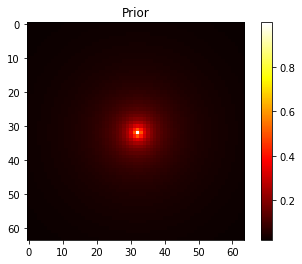

In [106]:
# More weight is given to the neurons on the right as a result of th
f = plt.figure()
NEURON_IDX = 26 if USE_MNIST else int(LAYER_SIZE//2 + LAYER_SIZE_SQ//2)

show_activations(f.add_subplot(1,1,1), prior[NEURON_IDX], "Prior")
np.sum(prior[NEURON_IDX])

### Data loading
---

In [107]:
kwargs = {}
if USE_MNIST:
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1000, shuffle=True, **kwargs)
else:
    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('/cvgl/group/ImageNet/Data/val', transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])),
        batch_size=256, shuffle=False,
        num_workers=20, pin_memory=False)


In [25]:
# Load data
for data, target in test_loader:
    break
batch = data.numpy()
data, target = Variable(data, volatile=True), Variable(target)

In [108]:
local_acts = local_model(data, return_activations=True)
classic_acts  = classic_model(data, return_activations=True)

In [109]:
len(local_acts)

3

In [47]:
def get_2d_mean(activation):
    activation = activation/np.sum(activation)
    coords = local.make_idx_arr(LAYER_SIZE_SQ,LAYER_SIZE_SQ)
    weighted_coords = np.multiply(coords, np.reshape(activation, (LAYER_SIZE_SQ,LAYER_SIZE_SQ,1)))
    weighted_coords = np.reshape(weighted_coords, (-1,2))
    return np.sum(weighted_coords, axis=0)

In [48]:
def get_2d_variance(activation):
    mean = get_2d_mean(activation)
    activation = activation/np.sum(activation)
    activation = np.reshape(activation, (LAYER_SIZE_SQ,LAYER_SIZE_SQ,1))
    coords = local.make_idx_arr(LAYER_SIZE_SQ,LAYER_SIZE_SQ)
    dists = activation * (coords - mean)**2
    unbias_weight = 1./(1.-np.sum(activation**2))
    return unbias_weight * np.sum(dists)

In [88]:
def denormalize(im):
    im = np.copy(im)
    im *= np.array([0.229, 0.224, 0.225])[:,np.newaxis,np.newaxis]
    im += np.array([0.485, 0.456, 0.406])[:,np.newaxis,np.newaxis]
    im = np.swapaxes(im, 0, 2)
    im = np.swapaxes(im, 0, 1)
    return im
    print(im.min(), im.max())

In [89]:
def show(local_activations, classic_activations, target, i, variances, counts):
    f = plt.figure(figsize=(12, 3))
    # f, axarr = plt.subplots(1, 3)
    ax = f.add_subplot(1, 3, 1)
    idx = (target.data.numpy()==i).argmax()

    ax.imshow(denormalize(batch[idx]))
    
    if local_activations is not None:
        act_local = average_activations(
                        local_activations, 
                        target.data.numpy(),
                        i)
        v_local = get_2d_variance(act_local)
        show_activations(f.add_subplot(1,3,2),
                     act_local,
                     "Local")
    else:
        v_local = None
    if classic_activations is not None:
        act_classic = average_activations(
                        classic_activations, 
                        target.data.numpy(),
                        i)
        v_classic = get_2d_variance(act_classic)
        show_activations(f.add_subplot(1,3,3),
                     act_classic,
                     "Classic")
    else:
        v_classic = None
    variances.append((v_local, v_classic))
    counts.append(idx.sum())
    
#     print "Center (local):", get_2d_mean(act_local)
#     print "Variance (local):", v_local
#     print "Center (classic):", get_2d_mean(act_classic)
#     print "Variance (classic):", v_classic


    plt.show()


In [90]:
def plot_variances(variances, counts):
    print("Variances:", np.sum(np.array(variances) * np.array(counts)[:,np.newaxis], axis=0))
    N = 10
    width = 0.35       # the width of the bars

    ind = np.arange(N)  # the x locations for the groups
    local_variances, classic_variances = zip(*variances)
    print(stats.ttest_rel(local_variances, classic_variances))
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, local_variances, width, color='r')
    rects2 = ax.bar(ind + width, classic_variances, width, color='y')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Variances')
    ax.set_title('Variance by class and model')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(k) for k in ind])

    ax.legend((rects1[0], rects2[0]), ('Local', 'Control'))


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

## FC1
--- 

FC1
N: 50
N: 50


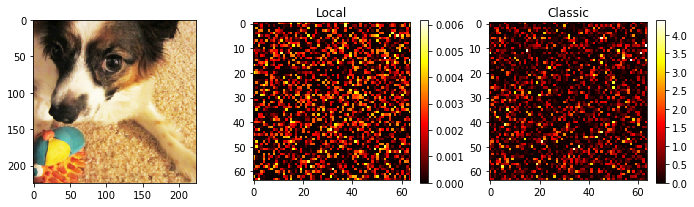

N: 50
N: 50


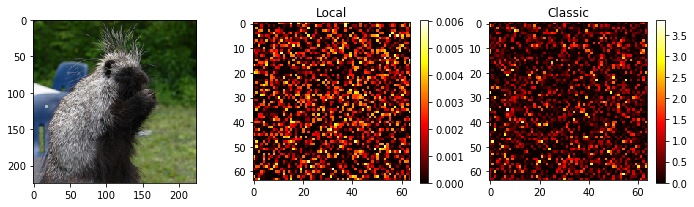

N: 50
N: 50


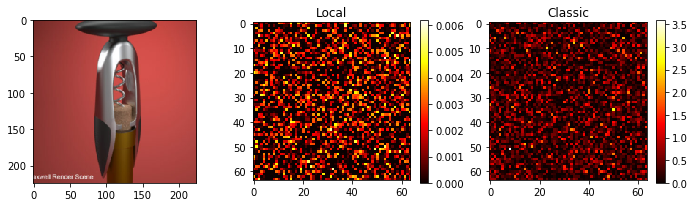

N: 6
N: 6


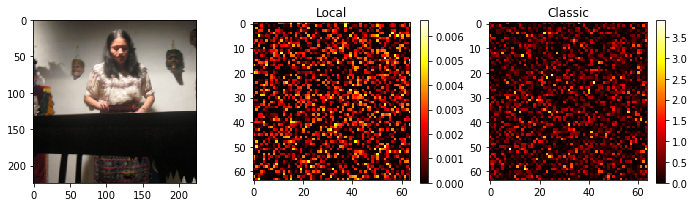

N: 50
N: 50


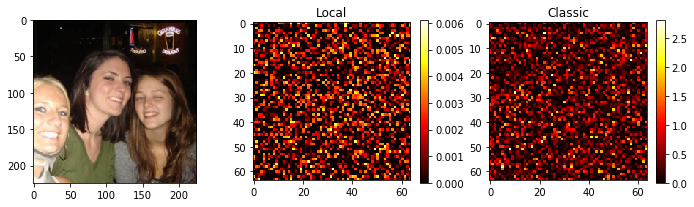

N: 50
N: 50


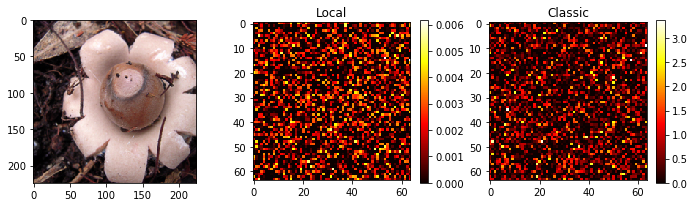

Variances: [ 502193.09178959  512384.66128499]
Ttest_relResult(statistic=-4.0515361436685779, pvalue=0.0098105194095814297)


ValueError: incompatible sizes: argument 'height' must be length 10 or scalar

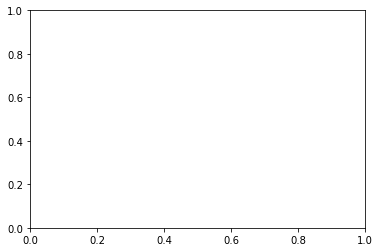

In [111]:
print("FC1")
if USE_MNIST:
    layer = 0
    local_activations = local_acts[layer].data.numpy()
    classic_activations = classic_acts[layer].data.numpy()
    layer_1_variances = []
    layer_1_counts = []
    for i in range(10):
        show(local_activations, classic_activations, target, i, 
             layer_1_variances, layer_1_counts)
    plot_variances(layer_1_variances, layer_1_counts)
else:
    layer = 0
    local_activations = local_acts[layer].data.cpu().numpy()
    classic_activations = classic_acts[layer].data.cpu().numpy()
    layer_1_variances = []
    layer_1_counts = []
    for i in np.unique(target.data.numpy()):
        show(local_activations, classic_activations, target, i, 
             layer_1_variances, layer_1_counts)
    plot_variances(layer_1_variances, layer_1_counts)

In [ ]:
plot_variances(layer_1_class_activations, layer_1_counts)

In [7]:
print np.mean(local_activations), np.mean(classic_activations)
print stats.ttest_rel(
    np.mean(local_activations, axis=1),
    np.mean(classic_activations, axis=1))

SyntaxError: invalid syntax (<ipython-input-7-2efe4c9d8c61>, line 1)

## FCLocal
---

FCLocal
N: 94
N: 94


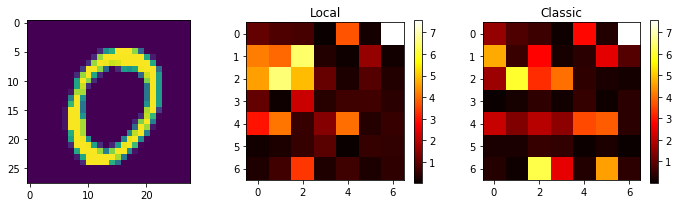

N: 115
N: 115


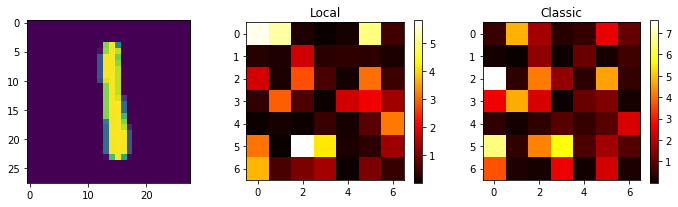

N: 109
N: 109


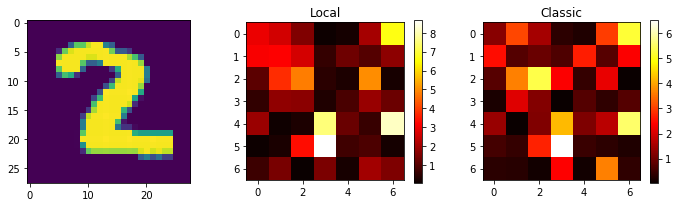

N: 90
N: 90


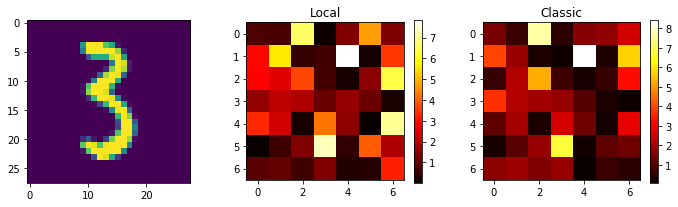

N: 96
N: 96


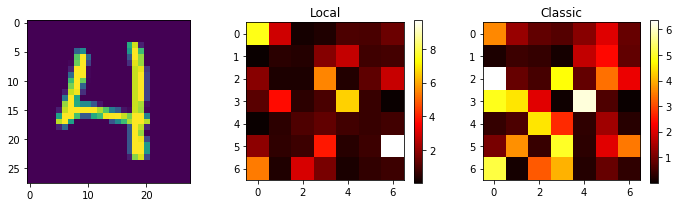

N: 87
N: 87


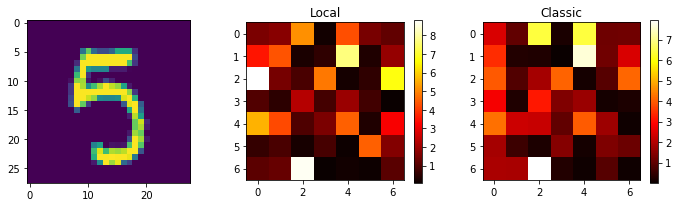

N: 90
N: 90


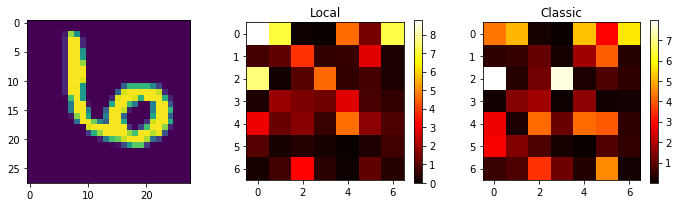

N: 117
N: 117


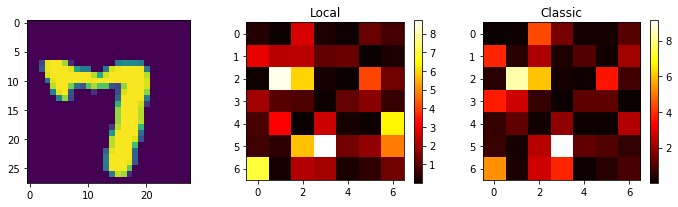

N: 98
N: 98


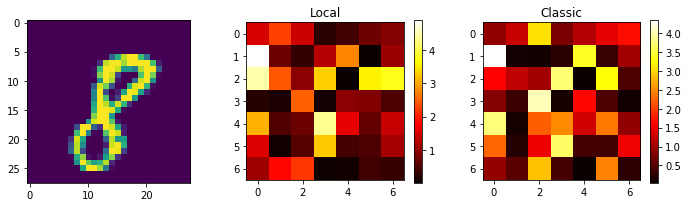

N: 104
N: 104


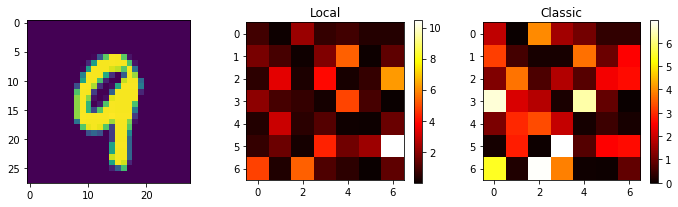

Variances: [ 527.75421672  516.51460832]
Ttest_relResult(statistic=1.1042492548305747, pvalue=0.29813169510299353)


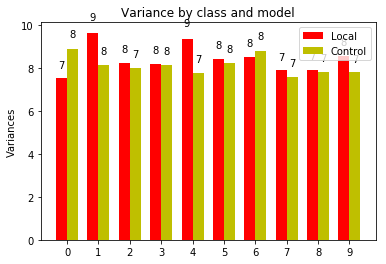

In [227]:
print "FCLocal"
layer = 1
local_activations = local_acts[layer].data.numpy()
classic_activations = classic_acts[layer].data.numpy()
layer_local_variances = []
layer_local_counts = []
for i in range(10):
    show(local_activations, classic_activations, target, i, 
         layer_local_variances, layer_local_counts)
plot_variances(layer_local_variances, layer_local_counts)

In [222]:
layer = 1
local_activations = local_acts[layer].data.numpy()
classic_activations = classic_acts[layer].data.numpy()

In [223]:
variances = []
counts = []

for k, _ in enumerate(target.data.numpy()):
    l = local_activations[k]
    c = classic_activations[k]
    variances.append((get_2d_variance(l), get_2d_variance(c)))

local_variances, classic_variances = zip(*variances)
print stats.ttest_rel(local_variances, classic_variances)

Ttest_relResult(statistic=7.2919438449164629, pvalue=6.2085569947006539e-13)


In [ ]:
print stats.ttest_rel(
    np.mean(local_activations, axis=1),
    np.mean(classic_activations, axis=1))
# np.mean(local_activations), np.mean(classic_activations)